<figure>
<center>
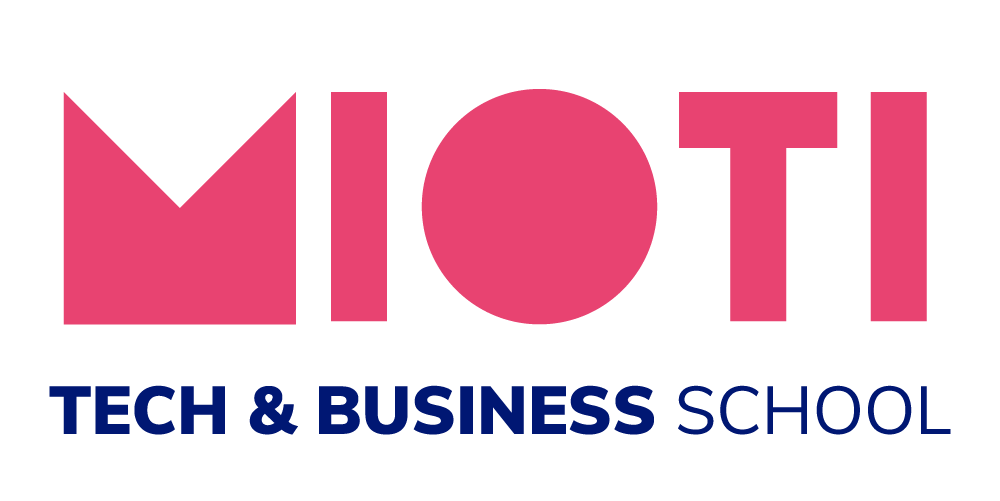
<figcaption></figcaption></center>
</figure>

## <center>Predictive Analytics<br/><br/>Scikit-learn time series</center>


# Regression Models Applied to Time Series (scikit-learn)

## Objective

The goal of this challenge is to develop a predictive model using a retail dataframe to forecast sales quantities for a specific item. To achieve this, we will begin by exploring the dataset to gain insights into the behavior of the selected item and identify any unique characteristics it may possess. 

Following this exploratory analysis, we will build a predictive model by experimenting with various models and using hyperparameter tuning. Finally, we will enhance the model's performance by incorporating relevant synthetic variables that can improve its understanding of the sales dynamics for the chosen product.

## 1. Environment Setup
Let's load the libraries that we will use for the challenge.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# optional - suppress warnings
import warnings
warnings.filterwarnings("ignore")

## 2. Data Loading and Preprocessig

Loading our dataframe as *df_retail* and translate the columns to English

In [12]:
df_retail = pd.read_csv('Dataframe_Retail.csv', delimiter=',')

df_retail.rename(columns={
    'Fecha': 'Date',
    'Referencia': 'Reference',
    'Unidades': 'Units',
    'Ventas': 'Sales'
}, inplace=True)

df_retail.head(10)

,Date,Reference,Units,Sales
0,2017-01-01,Cerveza tercio,18.000000,11.700000
1,2017-01-01,Baguetes 2 unidades,34.000000,33.320001
2,2017-01-02,Aceite de oliva virgen extra 5 l,53.000000,1184.550020
3,2017-01-02,Bolsa naranjas 2Kg.,1118.000000,1889.420064
4,2017-01-02,Mandarina,1752.468997,3356.279999
5,2017-01-02,Melo OR,399.428999,728.429999
6,2017-01-02,Baguetes 2 unidades,3572.000000,3257.839944
7,2017-01-02,Jamón reserva,48.515000,870.689999
8,2017-01-02,Cerveza tercio,1280.000000,802.150005
9,2017-01-02,Naranja en cajas,831.050001,1470.350000


Let's see how many items we have and what are their names

In [13]:
df_retail['Reference'].unique()

array(['Cerveza tercio', 'Baguetes 2 unidades',
       'Aceite de oliva virgen extra 5 l', 'Bolsa naranjas 2Kg.',
       'Mandarina', 'Melo  OR', 'Jamón reserva', 'Naranja en cajas',
       'Pack de plátanos', 'MERLUZA PALANGRE 1 - 2 Kg (1 Caja 10Q.)',
       'Tomate jugoso al peso', 'Filetes de salmón', 'Sepia',
       'Fresa premium 500gr'], dtype=object)

Now we filter our df_retail to create a new one only with the chosen item: **Jamón reserva**

In [14]:
df_jamon = df_retail[df_retail['Reference']=='Jamón reserva']
df_jamon.head(5)

,Date,Reference,Units,Sales
7,2017-01-02,Jamón reserva,48.515,870.689999
24,2017-01-03,Jamón reserva,63.325,1136.559994
38,2017-01-04,Jamón reserva,42.230,922.829997
46,2017-01-05,Jamón reserva,58.165,1273.139998
56,2017-01-07,Jamón reserva,71.330,1561.350001


Next step is to preprocess our filtered dataframe and create the time series

In [15]:
df_jamon['Date'] = pd.to_datetime(df_jamon['Date'], format='%Y-%m-%d')
df_jamon=df_jamon.set_index('Date')

In [16]:
# Let's check the range of datas in our dataframe
DateMin = df_jamon.index.min()
print(DateMin)

2017-01-02 00:00:00


In [17]:
DateMax = df_jamon.index.max()
print(DateMax)

2019-05-18 00:00:00


In [18]:
# Reindex the dataframe (df_jamon) to include all dates in the date range
date_range = pd.date_range(start=DateMin, end=DateMax,freq='d')
df_jamon = df_jamon.reindex(date_range)

# Treating the missing values
# Fill missing values in 'Unit' and 'Sales' columns with 0
df_jamon['Units']=df_jamon['Units'].fillna(value=0)
df_jamon['Sales']=df_jamon['Sales'].fillna(value=0)
# Fill missing values in the 'Referencia' column using forward fill method (ffill)
df_jamon['Reference']=df_jamon['Reference'].fillna(method='ffill')

# Reset dataframe index
df_jamon=df_jamon.reset_index()
df_jamon=df_jamon.rename(columns={'index':'Date Format'})

# Create a new column 'OffsetDays' that represents the index of the dataframe
df_jamon['OffsetDays'] = df_jamon.index

Let's examine the time series for *Jamón reserva* to ensure that we have one sales entry for each day within our specified range

In [19]:
df_jamon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 867 entries, 0 to 866
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date Format  867 non-null    datetime64[ns]
 1   Reference    867 non-null    object        
 2   Units        867 non-null    float64       
 3   Sales        867 non-null    float64       
 4   OffsetDays   867 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 34.0+ KB


In [20]:
df_jamon.tail(15)

,Date Format,Reference,Units,Sales,OffsetDays
852,2019-05-04,Jamón reserva,93.200,1698.480005,852
853,2019-05-05,Jamón reserva,0.000,0.000000,853
854,2019-05-06,Jamón reserva,57.605,1152.550004,854
855,2019-05-07,Jamón reserva,87.625,1655.840000,855
856,2019-05-08,Jamón reserva,82.815,1406.530000,856
857,2019-05-09,Jamón reserva,99.660,1737.949991,857
858,2019-05-10,Jamón reserva,142.516,2517.459991,858
859,2019-05-11,Jamón reserva,58.800,1014.130000,859
860,2019-05-12,Jamón reserva,0.000,0.000000,860
861,2019-05-13,Jamón reserva,104.325,1812.629994,861


In [21]:
df_jamon.head(15)

,Date Format,Reference,Units,Sales,OffsetDays
0,2017-01-02,Jamón reserva,48.515,870.689999,0
1,2017-01-03,Jamón reserva,63.325,1136.559994,1
2,2017-01-04,Jamón reserva,42.230,922.829997,2
3,2017-01-05,Jamón reserva,58.165,1273.139998,3
4,2017-01-06,Jamón reserva,0.000,0.000000,4
5,2017-01-07,Jamón reserva,71.330,1561.350001,5
6,2017-01-08,Jamón reserva,0.075,1.640000,6
7,2017-01-09,Jamón reserva,39.155,857.149997,7
8,2017-01-10,Jamón reserva,37.225,814.880001,8
9,2017-01-11,Jamón reserva,34.055,745.500002,9


<Axes: >

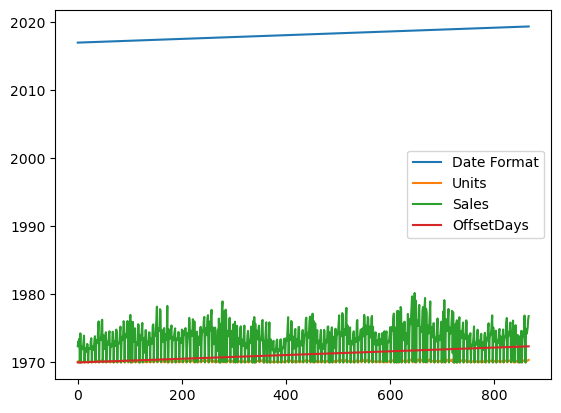

In [22]:
# Now we can plot a graphic to see how our time series looks like 
df_jamon.plot()

## 3. Testing the Prediction with Different Models

To evaluate the effectiveness of various predictive models on our sales database, we will use the evaluation function created below. With this function we can assess the performance of each model, allowing us to identify which approach provides the most accurate forecasts for the number of units sold.

In [23]:
def calculoEvaluacionModelo(modelo,df,norm):

    xPredicted = []
    yPredicted = []
    ySpotted = []
    mean_error = []

    # Using the last two months, we evaluate the chosen model
    for day in range(800,861):
        train = df[df['OffsetDays'] < day]
        val = df[df['OffsetDays'] == day]       
        
        xtr, xts = train.drop(['Date Format','Reference','Units'], axis=1), val.drop(['Date Format','Reference','Units'], axis=1)
        
        if(norm==True):
            sc = StandardScaler()  
            xtr = sc.fit_transform(xtr)  
            xts = sc.transform(xts)  
        ytr, yts = train['Units'].values, val['Units'].values  

        mdl = modelo
        mdl.fit(xtr, ytr)

        p = mdl.predict(xts)

        xPredicted=xPredicted + [day]
        yPredicted=yPredicted + [p[0]]
        ySpotted = ySpotted + [yts[0]]

        error = mean_absolute_error(yts, p)
        print('Day %d - Error %.5f' % (day, error))
        mean_error.append(error)

    print('Mean Error = %.5f' % np.mean(mean_error))
    prediction = pd.DataFrame(
        {'Sold units predicted': yPredicted,
         'Sold units actually spotted': ySpotted
        },index=xPredicted)
    prediction.plot()

### Linear Regression

Day 800 - Error 2.56024
Day 801 - Error 5.10435
Day 802 - Error 7.54597
Day 803 - Error 13.40819
Day 804 - Error 1.42606
Day 805 - Error 7.46336
Day 806 - Error 7.55341
Day 807 - Error 6.27395
Day 808 - Error 1.50846
Day 809 - Error 5.38303
Day 810 - Error 7.34366
Day 811 - Error 1.47429
Day 812 - Error 6.56683
Day 813 - Error 1.35827
Day 814 - Error 3.93697
Day 815 - Error 2.94412
Day 816 - Error 7.06085
Day 817 - Error 0.97372
Day 818 - Error 1.32548
Day 819 - Error 7.29104
Day 820 - Error 5.70910
Day 821 - Error 4.71861
Day 822 - Error 8.94294
Day 823 - Error 6.39859
Day 824 - Error 0.84483
Day 825 - Error 1.42836
Day 826 - Error 1.84578
Day 827 - Error 0.32603
Day 828 - Error 2.86512
Day 829 - Error 1.54662
Day 830 - Error 3.86473
Day 831 - Error 1.93814
Day 832 - Error 1.51756
Day 833 - Error 3.57020
Day 834 - Error 0.68458
Day 835 - Error 0.70007
Day 836 - Error 9.63882
Day 837 - Error 1.62885
Day 838 - Error 3.65792
Day 839 - Error 1.66259
Day 840 - Error 1.63192
Day 841 - Error

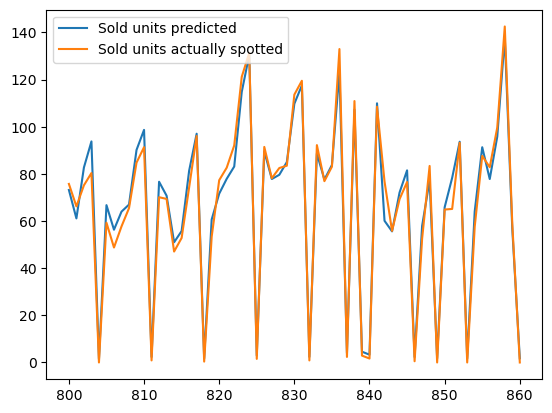

In [24]:
calculoEvaluacionModelo(LinearRegression(),df_jamon,True)

### KNeighbours Regression

Day 800 - Error 3.98500
Day 801 - Error 7.82000
Day 802 - Error 1.91333
Day 803 - Error 15.06167
Day 804 - Error 0.15333
Day 805 - Error 4.13333
Day 806 - Error 3.26833
Day 807 - Error 1.22167
Day 808 - Error 7.60500
Day 809 - Error 3.09333
Day 810 - Error 7.90333
Day 811 - Error 0.72167
Day 812 - Error 8.18667
Day 813 - Error 3.47333
Day 814 - Error 2.08667
Day 815 - Error 2.39500
Day 816 - Error 6.19000
Day 817 - Error 11.56667
Day 818 - Error 0.01667
Day 819 - Error 7.14167
Day 820 - Error 4.34833
Day 821 - Error 6.45333
Day 822 - Error 14.51833
Day 823 - Error 3.86167
Day 824 - Error 5.45667
Day 825 - Error 1.10833
Day 826 - Error 8.27500
Day 827 - Error 0.43500
Day 828 - Error 1.21667
Day 829 - Error 0.00167
Day 830 - Error 4.49633
Day 831 - Error 2.49000
Day 832 - Error 0.05500
Day 833 - Error 9.01500
Day 834 - Error 0.05000
Day 835 - Error 0.50833
Day 836 - Error 5.37200
Day 837 - Error 1.26500
Day 838 - Error 4.29567
Day 839 - Error 1.33167
Day 840 - Error 0.09167
Day 841 - Err

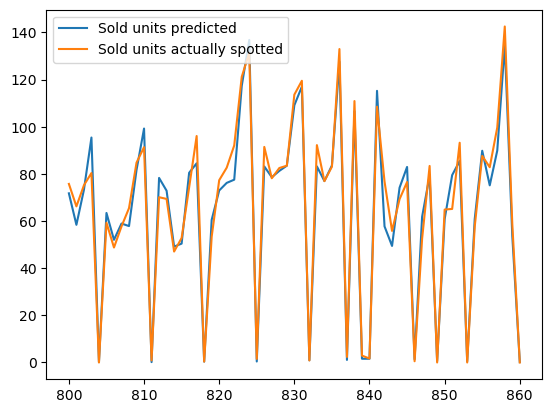

In [25]:
calculoEvaluacionModelo(KNeighborsRegressor(n_neighbors=3),df_jamon,False)

### MLP Regression 

Day 800 - Error 9.01027
Day 801 - Error 16.68322
Day 802 - Error 3.61027
Day 803 - Error 14.52497
Day 804 - Error 0.81261
Day 805 - Error 0.32458
Day 806 - Error 1.98441
Day 807 - Error 1.51354
Day 808 - Error 2.36868
Day 809 - Error 0.21315
Day 810 - Error 0.25263
Day 811 - Error 0.66170
Day 812 - Error 0.67727
Day 813 - Error 5.01543
Day 814 - Error 0.29924
Day 815 - Error 0.40825
Day 816 - Error 0.68246
Day 817 - Error 2.88150
Day 818 - Error 0.44338
Day 819 - Error 2.24978
Day 820 - Error 11.91152
Day 821 - Error 9.85306
Day 822 - Error 13.85801
Day 823 - Error 9.41952
Day 824 - Error 0.51048
Day 825 - Error 0.09592
Day 826 - Error 7.84637
Day 827 - Error 5.26962
Day 828 - Error 3.73081
Day 829 - Error 5.84989
Day 830 - Error 8.90748
Day 831 - Error 5.59975
Day 832 - Error 0.64310
Day 833 - Error 8.23409
Day 834 - Error 2.03508
Day 835 - Error 2.62210
Day 836 - Error 13.29147
Day 837 - Error 0.22066
Day 838 - Error 8.26146
Day 839 - Error 0.09785
Day 840 - Error 0.77543
Day 841 - E

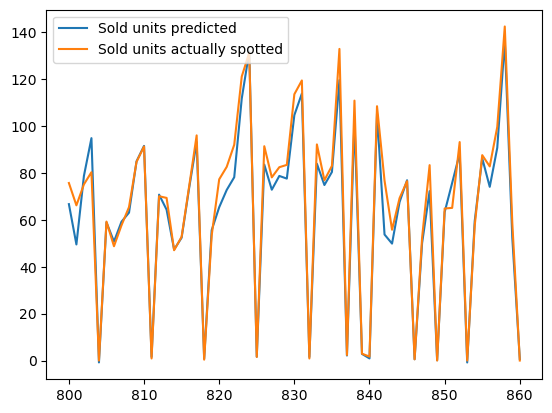

In [26]:
calculoEvaluacionModelo(MLPRegressor(),df_jamon,False)

### SVR Model

Day 800 - Error 4.58444
Day 801 - Error 8.92427
Day 802 - Error 8.20403
Day 803 - Error 17.36818
Day 804 - Error 0.32988
Day 805 - Error 4.41392
Day 806 - Error 3.89748
Day 807 - Error 2.97738
Day 808 - Error 1.55608
Day 809 - Error 8.62839
Day 810 - Error 12.58657
Day 811 - Error 0.47467
Day 812 - Error 5.90575
Day 813 - Error 0.75917
Day 814 - Error 0.93208
Day 815 - Error 0.58533
Day 816 - Error 7.76179
Day 817 - Error 5.68591
Day 818 - Error 0.33107
Day 819 - Error 4.19116
Day 820 - Error 7.78105
Day 821 - Error 5.09901
Day 822 - Error 7.89634
Day 823 - Error 0.54751
Day 824 - Error 5.74274
Day 825 - Error 0.33686
Day 826 - Error 1.29658
Day 827 - Error 0.35811
Day 828 - Error 2.31967
Day 829 - Error 3.67700
Day 830 - Error 1.74313
Day 831 - Error 2.89204
Day 832 - Error 0.30452
Day 833 - Error 1.62795
Day 834 - Error 0.91707
Day 835 - Error 1.89587
Day 836 - Error 5.16974
Day 837 - Error 0.35023
Day 838 - Error 0.73230
Day 839 - Error 0.23066
Day 840 - Error 0.15967
Day 841 - Erro

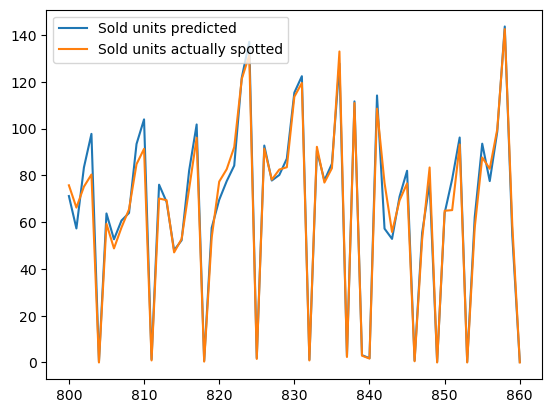

In [27]:
calculoEvaluacionModelo(SVR(C = 200) ,df_jamon,False)

As we can see, we achieved better results with the **SVR Model**, so we will proceed with this approach, now using the whole dataframe.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 867 entries, 0 to 866
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   OffsetDays   867 non-null    int64         
 1   Reference    867 non-null    object        
 2   Date Format  867 non-null    datetime64[ns]
 3   Units        867 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 27.2+ KB
Day 800 - Error 20.37749
Day 801 - Error 8.66078
Day 802 - Error 17.30924
Day 803 - Error 22.34719
Day 804 - Error 57.79809
Day 805 - Error 2.15559
Day 806 - Error 8.17202
Day 807 - Error 1.45992
Day 808 - Error 9.40158
Day 809 - Error 27.97527
Day 810 - Error 34.71873
Day 811 - Error 55.94608
Day 812 - Error 14.29686
Day 813 - Error 13.33660
Day 814 - Error 8.84895
Day 815 - Error 2.45157
Day 816 - Error 20.08563
Day 817 - Error 41.58890
Day 818 - Error 54.09394
Day 819 - Error 0.29832
Day 820 - Error 24.22740
Day

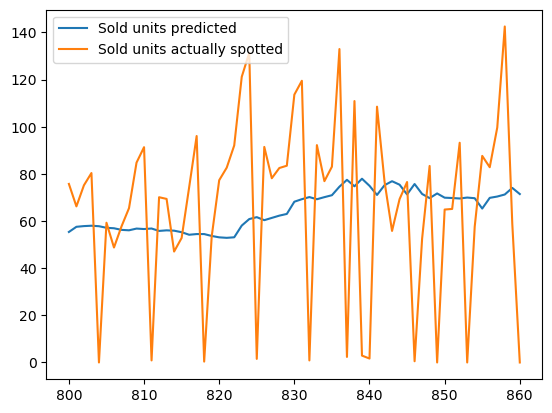

In [29]:
norma=False
df_jamon_simple = df_jamon[['OffsetDays','Reference','Date Format','Units']].copy()
df_jamon_simple.info()


calculoEvaluacionModelo(SVR(C = 200),df_jamon_simple,False)

## 4. Enhancing our Model with Synthetic Variables

Based on your observations of the behavior of the sold units for your Reference, we create now synthetic variables that we believe will help improve the model's predictions.

### Using Lags y Diffs

In [30]:
df_jamon_simple2 = df_jamon_simple.copy()
df_jamon_simple2['Units_prev'] = df_jamon_simple2['Units'].shift()
df_jamon_simple2['Units_Diff'] = df_jamon_simple2['Units_prev'].diff()
df_jamon_simple2.head()

,OffsetDays,Reference,Date Format,Units,Units_prev,Units_Diff
0,0,Jamón reserva,2017-01-02,48.515,NaN,NaN
1,1,Jamón reserva,2017-01-03,63.325,48.515,NaN
2,2,Jamón reserva,2017-01-04,42.230,63.325,14.810
3,3,Jamón reserva,2017-01-05,58.165,42.230,-21.095
4,4,Jamón reserva,2017-01-06,0.000,58.165,15.935


In [31]:
df_jamon_simple2 = df_jamon_simple2.dropna()

Day 800 - Error 2.70298
Day 801 - Error 4.23250
Day 802 - Error 7.40975
Day 803 - Error 9.84717
Day 804 - Error 74.27097
Day 805 - Error 2.06806
Day 806 - Error 9.53532
Day 807 - Error 1.58544
Day 808 - Error 6.14628
Day 809 - Error 21.21645
Day 810 - Error 19.06351
Day 811 - Error 77.03028
Day 812 - Error 8.87886
Day 813 - Error 8.60477
Day 814 - Error 22.09152
Day 815 - Error 9.24111
Day 816 - Error 15.99087
Day 817 - Error 28.94852
Day 818 - Error 76.35949
Day 819 - Error 10.27745
Day 820 - Error 23.24288
Day 821 - Error 15.29424
Day 822 - Error 19.31032
Day 823 - Error 44.37883
Day 824 - Error 45.15135
Day 825 - Error 90.81113
Day 826 - Error 14.25411
Day 827 - Error 5.77407
Day 828 - Error 7.85351
Day 829 - Error 8.58614
Day 830 - Error 37.17091
Day 831 - Error 30.97127
Day 832 - Error 94.03382
Day 833 - Error 18.70613
Day 834 - Error 0.75419
Day 835 - Error 5.79707
Day 836 - Error 54.74072
Day 837 - Error 93.06726
Day 838 - Error 26.70209
Day 839 - Error 80.89951
Day 840 - Error 

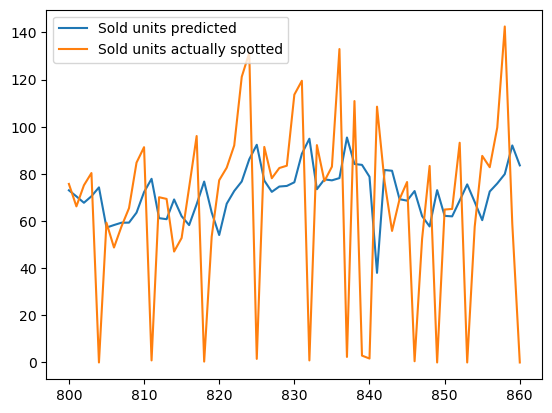

In [32]:
calculoEvaluacionModelo(SVR(C = 200),df_jamon_simple2,False)

### Adding week days to the dataframe

In [33]:
df_jamon_simple2.head()
df_jamon_simple2['Week day'] = df_jamon_simple2['Date Format'].dt.dayofweek

In [34]:
df_jamon_simple2.head(10)

,OffsetDays,Reference,Date Format,Units,Units_prev,Units_Diff,Week day
2,2,Jamón reserva,2017-01-04,42.230,63.325,14.810,2
3,3,Jamón reserva,2017-01-05,58.165,42.230,-21.095,3
4,4,Jamón reserva,2017-01-06,0.000,58.165,15.935,4
5,5,Jamón reserva,2017-01-07,71.330,0.000,-58.165,5
6,6,Jamón reserva,2017-01-08,0.075,71.330,71.330,6
7,7,Jamón reserva,2017-01-09,39.155,0.075,-71.255,0
8,8,Jamón reserva,2017-01-10,37.225,39.155,39.080,1
9,9,Jamón reserva,2017-01-11,34.055,37.225,-1.930,2
10,10,Jamón reserva,2017-01-12,32.360,34.055,-3.170,3
11,11,Jamón reserva,2017-01-13,51.300,32.360,-1.695,4


In [35]:
df_jamon_simple2['Monday'] =  df_jamon_simple2['Week day'].apply(lambda x: 1 if (x==0) else 0) 
df_jamon_simple2['Tuesday'] =  df_jamon_simple2['Week day'].apply(lambda x: 1 if (x==1) else 0) 
df_jamon_simple2['Wednesday'] =  df_jamon_simple2['Week day'].apply(lambda x: 1 if (x==2) else 0) 
df_jamon_simple2['Thursday'] =  df_jamon_simple2['Week day'].apply(lambda x: 1 if (x==3) else 0) 
df_jamon_simple2['Friday'] =  df_jamon_simple2['Week day'].apply(lambda x: 1 if (x==4) else 0) 
df_jamon_simple2['Saturday'] =  df_jamon_simple2['Week day'].apply(lambda x: 1 if (x==5) else 0) 
df_jamon_simple2['Sunday'] =  df_jamon_simple2['Week day'].apply(lambda x: 1 if (x==6) else 0) 

In [36]:
df_jamon_lag_days = df_jamon_simple2[['OffsetDays','Date Format', 'Reference','Units','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']].copy()

df_jamon_lag_days['Units_prev1'] = df_jamon_lag_days['Units'].shift(1)
df_jamon_lag_days['Units_prev2'] = df_jamon_lag_days['Units'].shift(2)
df_jamon_lag_days['Units_prev3'] = df_jamon_lag_days['Units'].shift(3)
df_jamon_lag_days['Units_prev4'] = df_jamon_lag_days['Units'].shift(4)
df_jamon_lag_days['Units_prev5'] = df_jamon_lag_days['Units'].shift(5)
df_jamon_lag_days['Units_prev6'] = df_jamon_lag_days['Units'].shift(6)
df_jamon_lag_days['Units_prev7'] = df_jamon_lag_days['Units'].shift(7)

df_jamon_lag_days=df_jamon_lag_days.dropna()
df_jamon_lag_days.head()

,OffsetDays,Date Format,Reference,Units,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Units_prev1,Units_prev2,Units_prev3,Units_prev4,Units_prev5,Units_prev6,Units_prev7
9,9,2017-01-11,Jamón reserva,34.055,0,0,1,0,0,0,0,37.225,39.155,0.075,71.330,0.000,58.165,42.230
10,10,2017-01-12,Jamón reserva,32.360,0,0,0,1,0,0,0,34.055,37.225,39.155,0.075,71.330,0.000,58.165
11,11,2017-01-13,Jamón reserva,51.300,0,0,0,0,1,0,0,32.360,34.055,37.225,39.155,0.075,71.330,0.000
12,12,2017-01-14,Jamón reserva,65.645,0,0,0,0,0,1,0,51.300,32.360,34.055,37.225,39.155,0.075,71.330
13,13,2017-01-15,Jamón reserva,0.595,0,0,0,0,0,0,1,65.645,51.300,32.360,34.055,37.225,39.155,0.075


Day 800 - Error 29.62625
Day 801 - Error 13.50850
Day 802 - Error 27.99000
Day 803 - Error 21.16600
Day 804 - Error 0.64050
Day 805 - Error 1.82700
Day 806 - Error 21.58025
Day 807 - Error 9.24325
Day 808 - Error 7.41550
Day 809 - Error 5.51325
Day 810 - Error 0.90925
Day 811 - Error 0.67000
Day 812 - Error 11.79125
Day 813 - Error 6.65175
Day 814 - Error 25.61725
Day 815 - Error 0.44750
Day 816 - Error 1.19200
Day 817 - Error 7.36450
Day 818 - Error 1.41775
Day 819 - Error 5.01425
Day 820 - Error 22.34275
Day 821 - Error 38.40675
Day 822 - Error 5.01125
Day 823 - Error 9.05700
Day 824 - Error 1.44525
Day 825 - Error 1.19800
Day 826 - Error 4.23050
Day 827 - Error 13.27575
Day 828 - Error 1.94975
Day 829 - Error 0.21425
Day 830 - Error 4.25800
Day 831 - Error 3.43020
Day 832 - Error 0.43125
Day 833 - Error 12.06125
Day 834 - Error 12.06300
Day 835 - Error 1.25000
Day 836 - Error 46.28800
Day 837 - Error 122.88530
Day 838 - Error 16.91175
Day 839 - Error 3.86625
Day 840 - Error 40.39500

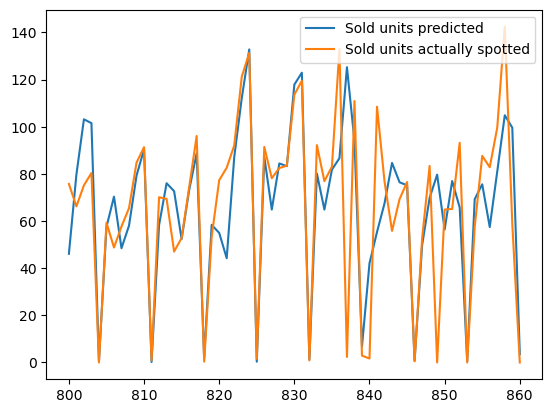

In [37]:
calculoEvaluacionModelo(RandomForestRegressor(n_estimators=20, random_state=0),df_jamon_lag_days,norma)

### Adding months to the dataframe

In [38]:
df_jamon_simple2['Month'] = df_jamon_simple2['Date Format'].dt.month

In [39]:
df_jamon_simple2.head()

,OffsetDays,Reference,Date Format,Units,Units_prev,Units_Diff,Week day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Month
2,2,Jamón reserva,2017-01-04,42.230,63.325,14.810,2,0,0,1,0,0,0,0,1
3,3,Jamón reserva,2017-01-05,58.165,42.230,-21.095,3,0,0,0,1,0,0,0,1
4,4,Jamón reserva,2017-01-06,0.000,58.165,15.935,4,0,0,0,0,1,0,0,1
5,5,Jamón reserva,2017-01-07,71.330,0.000,-58.165,5,0,0,0,0,0,1,0,1
6,6,Jamón reserva,2017-01-08,0.075,71.330,71.330,6,0,0,0,0,0,0,1,1


In [40]:
df_jamon_simple2['January'] = df_jamon_simple2['Month'].apply(lambda x: 1 if (x == 1) else 0) 
df_jamon_simple2['February'] = df_jamon_simple2['Month'].apply(lambda x: 1 if (x == 2) else 0) 
df_jamon_simple2['March'] = df_jamon_simple2['Month'].apply(lambda x: 1 if (x == 3) else 0) 
df_jamon_simple2['April'] = df_jamon_simple2['Month'].apply(lambda x: 1 if (x == 4) else 0) 
df_jamon_simple2['May'] = df_jamon_simple2['Month'].apply(lambda x: 1 if (x == 5) else 0) 
df_jamon_simple2['June'] = df_jamon_simple2['Month'].apply(lambda x: 1 if (x == 6) else 0) 
df_jamon_simple2['July'] = df_jamon_simple2['Month'].apply(lambda x: 1 if (x == 7) else 0) 
df_jamon_simple2['August'] = df_jamon_simple2['Month'].apply(lambda x: 1 if (x == 8) else 0) 
df_jamon_simple2['September'] = df_jamon_simple2['Month'].apply(lambda x: 1 if (x == 9) else 0) 
df_jamon_simple2['October'] = df_jamon_simple2['Month'].apply(lambda x: 1 if (x == 10) else 0) 
df_jamon_simple2['November'] = df_jamon_simple2['Month'].apply(lambda x: 1 if (x == 11) else 0) 
df_jamon_simple2['December'] = df_jamon_simple2['Month'].apply(lambda x: 1 if (x == 12) else 0)

In [41]:
df_jamon_lag_days_month = df_jamon_simple2[['OffsetDays','Date Format', 'Reference','Units','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','January','February','March','April','May', 'June', 'July', 'August','September','October','November','December']].copy()

df_jamon_lag_days_month['Units_prev1'] = df_jamon_lag_days_month['Units'].shift(1)
df_jamon_lag_days_month['Units_prev2'] = df_jamon_lag_days_month['Units'].shift(2)
df_jamon_lag_days_month['Units_prev3'] = df_jamon_lag_days_month['Units'].shift(3)
df_jamon_lag_days_month['Units_prev4'] = df_jamon_lag_days_month['Units'].shift(4)
df_jamon_lag_days_month['Units_prev5'] = df_jamon_lag_days_month['Units'].shift(5)
df_jamon_lag_days_month['Units_prev6'] = df_jamon_lag_days_month['Units'].shift(6)
df_jamon_lag_days_month['Units_prev7'] = df_jamon_lag_days_month['Units'].shift(7)

df_jamon_lag_days_month=df_jamon_lag_days_month.dropna()
df_jamon_lag_days_month.head()

,OffsetDays,Date Format,Reference,Units,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,...,October,November,December,Units_prev1,Units_prev2,Units_prev3,Units_prev4,Units_prev5,Units_prev6,Units_prev7
9,9,2017-01-11,Jamón reserva,34.055,0,0,1,0,0,0,...,0,0,0,37.225,39.155,0.075,71.330,0.000,58.165,42.230
10,10,2017-01-12,Jamón reserva,32.360,0,0,0,1,0,0,...,0,0,0,34.055,37.225,39.155,0.075,71.330,0.000,58.165
11,11,2017-01-13,Jamón reserva,51.300,0,0,0,0,1,0,...,0,0,0,32.360,34.055,37.225,39.155,0.075,71.330,0.000
12,12,2017-01-14,Jamón reserva,65.645,0,0,0,0,0,1,...,0,0,0,51.300,32.360,34.055,37.225,39.155,0.075,71.330
13,13,2017-01-15,Jamón reserva,0.595,0,0,0,0,0,0,...,0,0,0,65.645,51.300,32.360,34.055,37.225,39.155,0.075


Day 800 - Error 25.06525
Day 801 - Error 19.48500
Day 802 - Error 30.02225
Day 803 - Error 21.52250
Day 804 - Error 0.14475
Day 805 - Error 5.35875
Day 806 - Error 15.05975
Day 807 - Error 5.82200
Day 808 - Error 2.86575
Day 809 - Error 6.48175
Day 810 - Error 1.67375
Day 811 - Error 0.57150
Day 812 - Error 15.36050
Day 813 - Error 3.66400
Day 814 - Error 21.89425
Day 815 - Error 0.81375
Day 816 - Error 2.86875
Day 817 - Error 8.22950
Day 818 - Error 0.46225
Day 819 - Error 6.64225
Day 820 - Error 18.81450
Day 821 - Error 34.09775
Day 822 - Error 10.37600
Day 823 - Error 5.82625
Day 824 - Error 3.82825
Day 825 - Error 1.00125
Day 826 - Error 2.27550
Day 827 - Error 9.43300
Day 828 - Error 0.29450
Day 829 - Error 3.27350
Day 830 - Error 0.14610
Day 831 - Error 4.76395
Day 832 - Error 0.04775
Day 833 - Error 14.84425
Day 834 - Error 8.23375
Day 835 - Error 2.32325
Day 836 - Error 45.48875
Day 837 - Error 124.19970
Day 838 - Error 5.05670
Day 839 - Error 0.98975
Day 840 - Error 38.25175
D

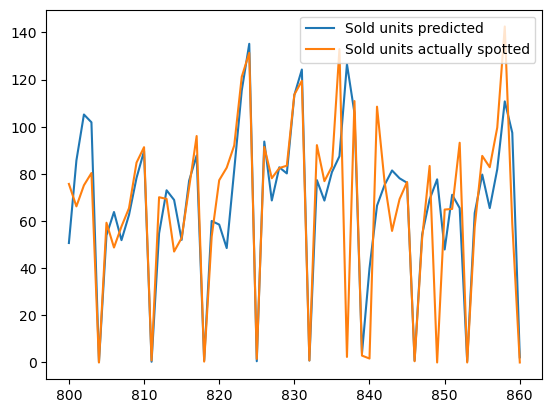

In [42]:
calculoEvaluacionModelo(RandomForestRegressor(n_estimators=20, random_state=0),df_jamon_lag_days_month,norma)

The final mean error achieved was 14,298%. This result indicates the average deviation between the predicted values and the actual sales data. While this error percentage provides insight into the model's performance, there is potential for improvement. Future iterations could involve further tuning of the model parameters, incorporating additional synthetic variables, or exploring alternative modeling techniques to enhance prediction accuracy.